In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from helpers import compute_proportion_of_votes
from sklearn.model_selection import train_test_split, KFold

2022-10-21 18:03:25.024364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-21 18:03:25.126968: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-21 18:03:25.130946: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/olivier/miniconda3/lib:/home/olivier/miniconda3/lib:
2022-10-21 18:03:25.130956: I tensorf

## Goal of the notebook

We want to predict second round results from first round results. To do so will use a neural network.

## Load data

In [2]:
# load election results
df_t1 = pd.read_csv('../data/presidentielle_t1.csv', low_memory=False)
df_t2 = pd.read_csv('../data/presidentielle_t2.csv', low_memory=False)

id_columns = [
    'CodeDepartement',
    'NomDepartement',
    'CodeCirconscription',
    'NomCirconscription',
    'CodeCommune',
    'NomCommune',
    'CodeBureauVote',
    'Inscrits']

choices_t1 = [
    'No_One',
    'Arthaud',
    'Roussel',
    'Macron',
    'Lassalle',
    'Le_Pen',
    'Zemmour',
    'Melenchon',
    'Hidalgo',
    'Jadot',
    'Pecresse',
    'Poutou',
    'Dupont_Aignan']

choices_t2 = [
    'No_One',
    'Macron',
    'Le_Pen']

# filter out voting stations with no choices
mask = ((df_t1["Votants"] - df_t1["No_One"] >= 30) & 
    (df_t2["Votants"] - df_t2["No_One"] >= 30))
df_t1 = df_t1.loc[mask, :].reset_index(drop=True)
df_t2 = df_t2.loc[mask, :].reset_index(drop=True)

# compute proportions
prop_t1 = compute_proportion_of_votes(df_t1, choices_t1)
prop_t2 = compute_proportion_of_votes(df_t2, choices_t2)

## Choosing a model

We will use k-fold cross-validation to identify the number of layers and neurons per layer. We first define a function that allows us to create a neural network using tensorflow.

In [3]:
def create_model(
        input_shape: int,
        output_shape: int,
        hidden_shape: int,
        hidden_n_layers: int,
        batch_norm: bool = False,
        activation="selu",
        kernel_initializer='lecun_normal',
        optimizer="adam",
        loss=tf.keras.losses.kl_divergence):
        
    '''Create neural network model.'''

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(
        input_shape,
        activation=activation,
        kernel_initializer=kernel_initializer))

    if batch_norm:
        model.add(tf.keras.layers.BatchNormalization())

    for _ in range(hidden_n_layers):
        model.add(tf.keras.layers.Dense(
            hidden_shape,
            activation=activation,
            kernel_initializer=kernel_initializer))
        if batch_norm:
            model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(
        output_shape,
        activation="softmax",
        kernel_initializer=kernel_initializer))

    model.compile(optimizer=optimizer, loss=loss)

    return model


We now set the hyperparameters of the model that we will be testing.

In [4]:
model_params = np.meshgrid(
    [5, 20, 50],
    [1, 3, 5],
    [False]
)
model_params = np.array(model_params).T.reshape(-1, 3)
model_params = pd.DataFrame(
    model_params,
    columns=["hidden_shape", "hidden_n_layers", "batch_norm"])
model_params

,hidden_shape,hidden_n_layers,batch_norm
0,5,1,0
1,5,3,0
2,5,5,0
3,20,1,0
4,20,3,0
5,20,5,0
6,50,1,0
7,50,3,0
8,50,5,0


We run the cross-validation.

In [5]:
train_prop_t1, test_prop_t1, train_prop_t2, test_prop_t2 = train_test_split(
    prop_t1, prop_t2, test_size=.2, random_state=63)

nkf = 5
results = np.zeros((model_params.shape[0], nkf))
kf = KFold(nkf, random_state=63, shuffle=True)

for kf_idx, (train_idx, val_idx) in enumerate(kf.split(train_prop_t1)):
    for param_idx in range(model_params.shape[0]):

        hidden_shape = model_params["hidden_shape"][param_idx]
        hidden_n_layers = model_params["hidden_n_layers"][param_idx]
        batch_norm = model_params["batch_norm"][param_idx]

        model = create_model(
            input_shape=prop_t1.shape[1],
            output_shape=prop_t2.shape[1],
            hidden_shape=hidden_shape,
            hidden_n_layers=hidden_n_layers,
            batch_norm=batch_norm)

        model.fit(
            x=train_prop_t1.iloc[train_idx, :],
            y=train_prop_t2.iloc[train_idx, :],
            epochs=10,
            verbose=0)

        error = model.evaluate(
            x=train_prop_t1.iloc[val_idx, :],
            y=train_prop_t2.iloc[val_idx, :],
            verbose=0)
        results[param_idx, kf_idx] = error

        print(f'{kf_idx=}, {param_idx=} {error=:.4f}')


2022-10-21 18:03:31.436143: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/olivier/miniconda3/lib:/home/olivier/miniconda3/lib:
2022-10-21 18:03:31.436164: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-21 18:03:31.436179: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2022-10-21 18:03:31.436365: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


kf_idx=0, param_idx=0 error=0.0034
kf_idx=0, param_idx=1 error=0.0033
kf_idx=0, param_idx=2 error=0.0032
kf_idx=0, param_idx=3 error=0.0035
kf_idx=0, param_idx=4 error=0.0032
kf_idx=0, param_idx=5 error=0.0031
kf_idx=0, param_idx=6 error=0.0033
kf_idx=0, param_idx=7 error=0.0032
kf_idx=0, param_idx=8 error=0.0033
kf_idx=1, param_idx=0 error=0.0033
kf_idx=1, param_idx=1 error=0.0034
kf_idx=1, param_idx=2 error=0.0035
kf_idx=1, param_idx=3 error=0.0032
kf_idx=1, param_idx=4 error=0.0032
kf_idx=1, param_idx=5 error=0.0037
kf_idx=1, param_idx=6 error=0.0032
kf_idx=1, param_idx=7 error=0.0032
kf_idx=1, param_idx=8 error=0.0034
kf_idx=2, param_idx=0 error=0.0033
kf_idx=2, param_idx=1 error=0.0034
kf_idx=2, param_idx=2 error=0.0033
kf_idx=2, param_idx=3 error=0.0033
kf_idx=2, param_idx=4 error=0.0032
kf_idx=2, param_idx=5 error=0.0032
kf_idx=2, param_idx=6 error=0.0032
kf_idx=2, param_idx=7 error=0.0032
kf_idx=2, param_idx=8 error=0.0032
kf_idx=3, param_idx=0 error=0.0033
kf_idx=3, param_idx=

We look at the distribution of errors for each model. There does not seem to be a very big difference.

<AxesSubplot: xlabel='param_index', ylabel='value'>

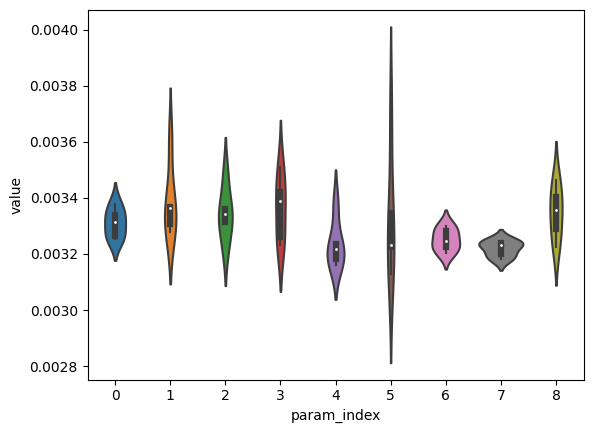

In [6]:
model_params_results = pd.concat([model_params, pd.DataFrame(results)], axis=1)
model_params_results["param_index"] = range(model_params_results.shape[0])

model_params_results_melt = model_params_results.melt(
    id_vars=list(model_params.columns)+["param_index"])

sns.violinplot(model_params_results_melt, x="param_index", y="value")


We look at the median error for each model. We that 3 layers with 20 neurons per layer seems to give the best results.

In [7]:
(model_params_results_melt
    .groupby(list(model_params.columns))["value"]
    .median()
    .sort_values())

hidden_shape  hidden_n_layers  batch_norm
20            3                0             0.003219
50            3                0             0.003232
20            5                0             0.003233
50            1                0             0.003246
5             1                0             0.003316
              5                0             0.003341
50            5                0             0.003357
5             3                0             0.003366
20            1                0             0.003388
Name: value, dtype: float64

## Estimating test error

We now estimate the test error of this final model.

In [10]:
model = create_model(
    input_shape=prop_t1.shape[1],
    output_shape=prop_t2.shape[1],
    hidden_shape=20,
    hidden_n_layers=3,
    batch_norm=False)
    
history = model.fit(
    x=train_prop_t1, 
    y=train_prop_t2,
    epochs=50, 
    validation_split=.1,
    verbose=0)

In [11]:
model.evaluate(
    x=test_prop_t1,
    y=test_prop_t2,
    verbose=0)

0.0034331008791923523

<AxesSubplot: >

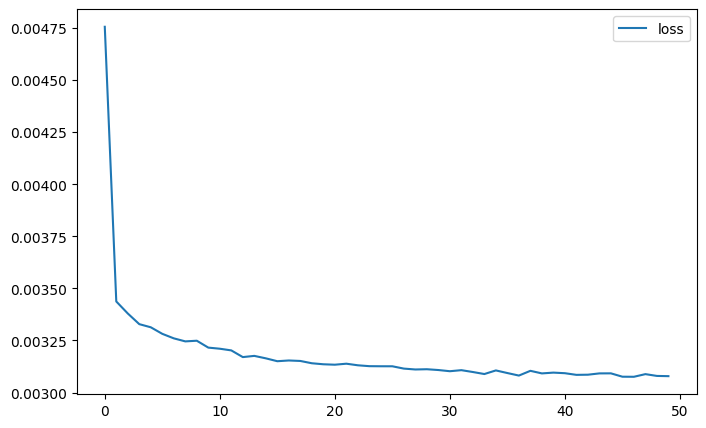

In [12]:
pd.DataFrame(history.history).plot(figsize=(8, 5))

## Fit final model

We now fit the final model with all the data.

In [14]:
final_model = create_model(
    input_shape=prop_t1.shape[1],
    output_shape=prop_t2.shape[1],
    hidden_shape=50,
    hidden_n_layers=3,
    batch_norm=False)
    
history = final_model.fit(
    x=prop_t1, 
    y=prop_t2,
    epochs=100, 
    validation_split=.1,
    verbose=0)

## Looking at predictions of model

In [16]:
# We retrieve predictions
prop_t2_hat = pd.DataFrame(final_model.predict(prop_t1))
prop_t2_hat.columns = prop_t2.columns
prop_t2_all = pd.merge(prop_t2, prop_t2_hat,
                       left_index=True, right_index=True,
                       suffixes=['_Observed', '_Predicted'])
prop_t2_all = pd.merge(df_t1[id_columns], prop_t2_all,
                       left_index=True, right_index=True)

# We compute the pointwise error per voting station
def error(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    y_true = tf.keras.backend.clip(y_true, tf.keras.backend.epsilon(), 1)
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1)
    return tf.math.abs(tf.math.log(y_true / y_pred))

for choice in choices_t2:
    prop_t2_all[f'{choice}_Residual'] = error(
        prop_t2_all[f'{choice}_Observed'], 
        prop_t2_all[f'{choice}_Predicted'])

2005/2005 [==============================] - 1s 422us/step


We first look at observed values against predicted values and overall see a good correlations.

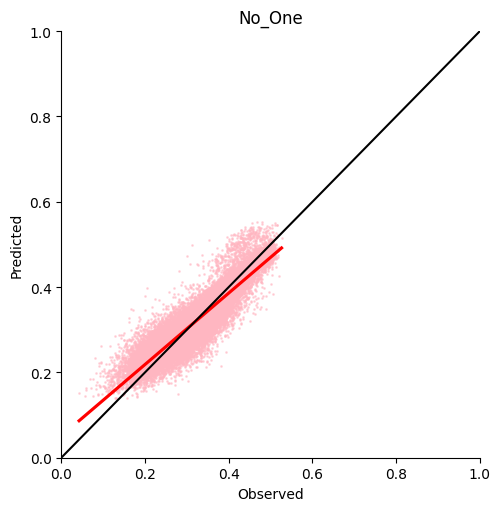

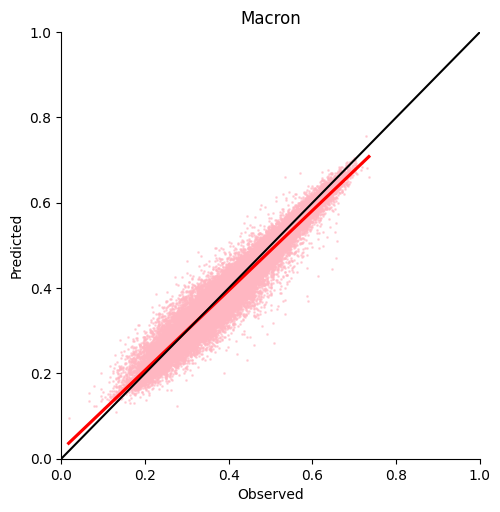

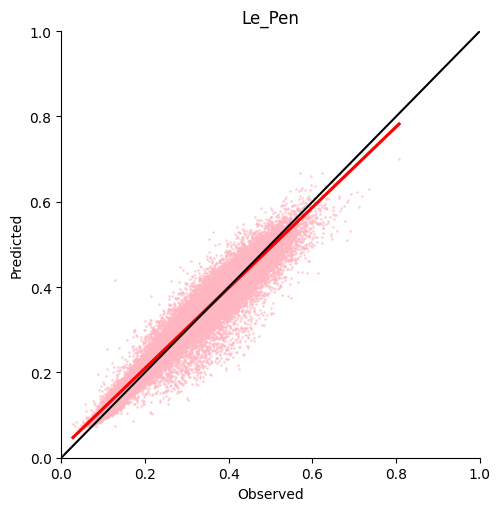

In [17]:
for choice in choices_t2:
    sns.lmplot(data=prop_t2_all,
               x=f'{choice}_Observed',
               y=f'{choice}_Predicted',
               line_kws={'color': 'red'},
               scatter_kws={'s': 1, 'color': '#ffb6c1', 'alpha': .5})
    plt.axline(xy1=(0, 0), slope=1, color='k')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title(choice)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')

However, there seems to be some structure in the error. The model does not predict equally well for every department. In particular it seems to perform significantly worse for departments outside metropolitan France.

In [18]:
prop_t2_all.groupby('CodeDepartement')[
    'Macron_Residual'].median().sort_values(ascending=False).head(25)

CodeDepartement
ZA    0.341653
ZC    0.293655
ZB    0.248870
ZS    0.152533
ZD    0.143640
ZP    0.103580
2B    0.074614
52    0.068042
ZM    0.066345
32    0.065408
10    0.065365
70    0.065034
55    0.064029
08    0.062264
02    0.060267
23    0.059038
ZN    0.058855
2A    0.058160
ZZ    0.056174
09    0.055760
39    0.055663
80    0.055233
88    0.054459
61    0.053191
36    0.052871
Name: Macron_Residual, dtype: float32

In [19]:
prop_t2_all.groupby('CodeDepartement')[
    'Le_Pen_Residual'].median().sort_values(ascending=False).head(25)

CodeDepartement
ZB    0.523091
ZA    0.480725
ZC    0.409009
ZS    0.394614
ZD    0.352022
ZW    0.269219
ZZ    0.251745
ZP    0.224255
75    0.079924
2B    0.078445
93    0.078119
64    0.078099
48    0.073027
65    0.068637
32    0.067643
94    0.067285
ZM    0.065590
92    0.064001
2A    0.063690
ZX    0.063160
46    0.059848
19    0.058848
39    0.057818
63    0.057063
12    0.056669
Name: Le_Pen_Residual, dtype: float32

In [20]:
prop_t2_all.groupby('CodeDepartement')[
    'No_One_Residual'].median().sort_values(ascending=False).head(25)

CodeDepartement
ZD    0.144551
ZP    0.095204
52    0.089365
ZW    0.082665
55    0.081164
70    0.075350
32    0.073390
48    0.073275
80    0.073115
08    0.071582
15    0.071563
39    0.069583
21    0.068764
10    0.068318
14    0.065369
23    0.064540
46    0.064381
61    0.064181
25    0.063435
02    0.063166
09    0.062941
ZX    0.062581
71    0.061385
2A    0.060959
87    0.060668
Name: No_One_Residual, dtype: float32

We also seem to be making higher errors when there are less registered voters.

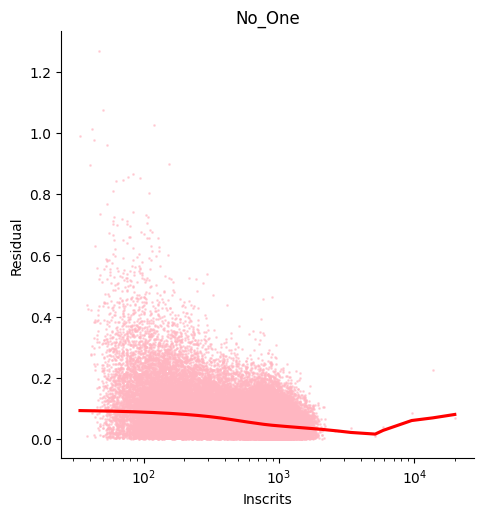

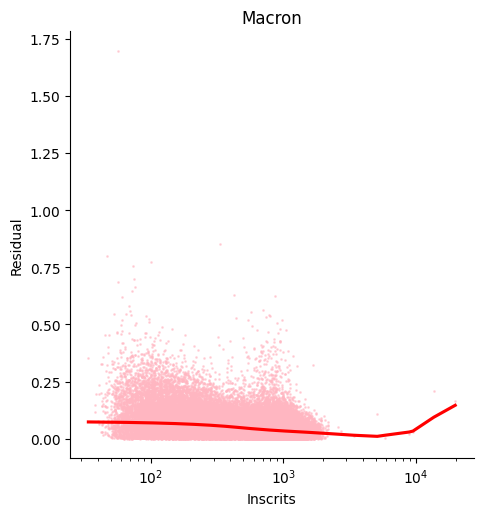

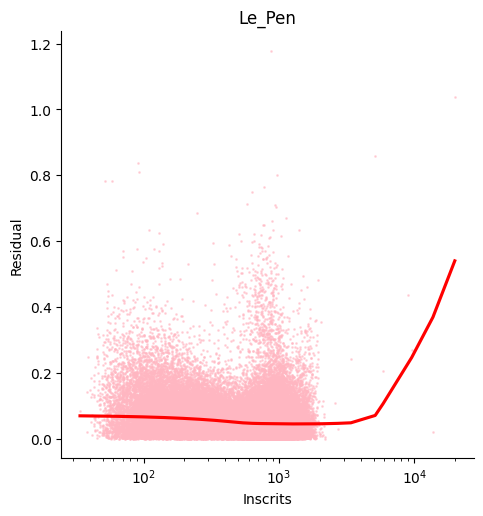

In [28]:
for choice in choices_t2:
    sns.lmplot(
        data=prop_t2_all,
        x='Inscrits',
        y=f'{choice}_Residual',
        line_kws={'color': 'red'},
        scatter_kws={'s': 1, 'color': '#ffb6c1', 'alpha': .5},
        lowess = True)
    plt.xscale("log")
    plt.ylabel("Residual")
    plt.title(choice)
    plt.show()
